<a href="https://colab.research.google.com/github/sebsteinig/analysis_mcglannan_2022/blob/master/notebook_mcglannan_2022_devono_mississippian_winds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title
short description of what the notebook does

# User input
define variables/lists to quickly change inputs to the notebook

In [ ]:
work_dir       = repo + '/'
expts          = ['teXpz', 'teXpy']

save_figures   = True

## Prelude
If running on Google Colab, execute the following two cells seperately to download the files and install the necessary conda environment on the virtual machine. This will take several minutes and involves restarting the kernel.

If running somewhere else, you can execute the whole notebooks and this part will be skipped automatically.

In [5]:
# configure environment on Colab
try:
    import google.colab

    # if on Colab, clone the repository to access the data locally
    import os
    repo = "analysis_template"

    # clone repo if it does not already exist
    if not os.path.exists(repo):
        !git clone https://github.com/sebsteinig/{repo}.git

    # install condacolab to easily handle conda environments on Colab
    !pip install -q condacolab
    import condacolab
    condacolab.install()
    
except:
    print('not running on Google Colab')

not running on Google Colab


In [6]:
try:
    import google.colab
    
    # install packages from environment.yml file
    !conda env update -n base -f environment.yml
    
except:
    print('not running on Google Colab')

not running on Google Colab


# Load packages

In [1]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import csv
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

from cartopy import config
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import cmocean
import shapefile as shp  # Requires the pyshp package
from shapely.geometry.polygon import Polygon


# Main code

# winds, orography and precipitation

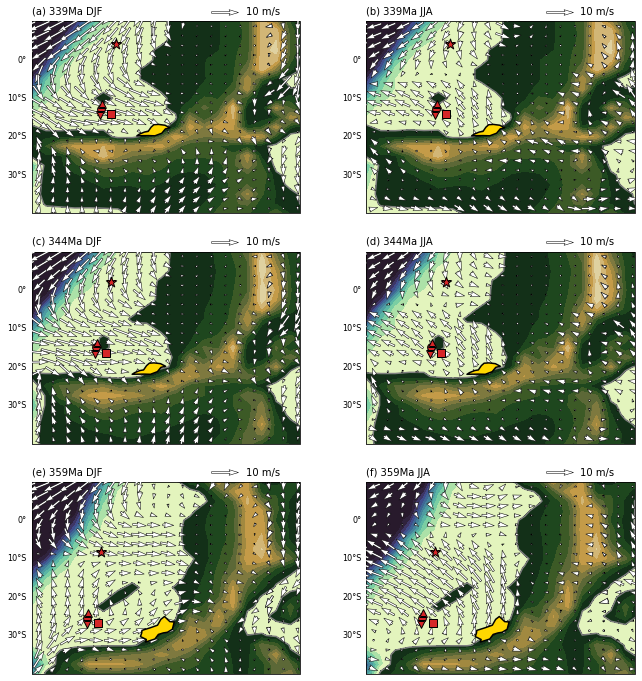

In [6]:
# loop over all models
# define figure layout first

expts          = ['teXpq', 'teXpr', 'teXpu']
labels         = ['339Ma', '344Ma', '359Ma']
panels         = ['(a)', '(b)', '(c)','(d)', '(e)', '(f)']

fig, axes = plt.subplots(len(expts), 2, figsize=(11, 12) )
    
plotRow = 0
    
for expCount, exp in enumerate(expts):

    # load data
    modelHeight = xr.open_dataset(data_dir + exp + '.modelHeight.nc', decode_times=False).modelHeight 
    latitude = xr.open_dataset(data_dir + exp + '.modelHeight.nc', decode_times=False).latitude 
    longitude = xr.open_dataset(data_dir + exp + '.modelHeight.nc', decode_times=False).longitude 

    lsm = xr.open_dataset(data_dir + exp + '.mask.nc', decode_times=False).lsm [0,0,:,:]
    
    uwnd = xr.open_dataset(data_dir + exp + '.pd.clim.nc', decode_times=False).u_mm_10m[:,0,:,:]
    vwnd = xr.open_dataset(data_dir + exp + '.pd.clim.nc', decode_times=False).v_mm_10m[:,0,:,:] 
    latitudeV = xr.open_dataset(data_dir + exp + '.pd.clim.nc', decode_times=False).latitude_1
    longitudeV = xr.open_dataset(data_dir + exp + '.pd.clim.nc', decode_times=False).longitude_1
    
    pr = xr.open_dataset(data_dir + exp + '.pd.clim.nc', decode_times=False).precip_mm_srf[:,0,:,:]*86400 

    # add cyclic longitude
    modelHeight_cyclic, longitude_cyclic = add_cyclic_point(modelHeight, coord=longitude)
    lsm_cyclic = add_cyclic_point(lsm)
    uwnd_cyclic,longitudeV_cyclic = add_cyclic_point(uwnd, coord=longitudeV)
    vwnd_cyclic = add_cyclic_point(vwnd)
    pr_cyclic = add_cyclic_point(pr)
    
    # DJF
    column = 0
    uwnd_DJF = uwnd_cyclic[[11,0,1],:,:].mean(axis=0)
    vwnd_DJF = vwnd_cyclic[[11,0,1],:,:].mean(axis=0)
    pr_DJF = pr_cyclic[[11,0,1],:,:].mean(axis=0)

    axes[expCount,column] = plt.subplot(len(expts), 2, plotRow * 2 + 1, projection=ccrs.PlateCarree())
    axes[expCount,column].set_extent([-60,10, -40,10], ccrs.PlateCarree())

    cf = axes[expCount,column].contourf(longitude_cyclic, latitude, modelHeight_cyclic, transform=ccrs.PlateCarree(),
                                        levels=21, vmin=-3000, vmax=3000, cmap=cmocean.cm.topo,
                                        add_colorbar=False,zorder=1, alpha=1.0 )
    
    cn = axes[expCount,column].contour(longitude_cyclic, latitude, modelHeight_cyclic, transform=ccrs.PlateCarree(),
                                    levels=[0.0], colors='gray',zorder=1)
                                     
        
    #cp = axes[expCount,column].contour(longitude_cyclic, latitude, pr_DJF, transform=ccrs.PlateCarree(),levels = [0, 4, 8, 12], cmap='BuPu', linewidths=2., linestyles='solid', zorder=2)

    #axes[expCount,column].clabel(cp, cp.levels, inline=True, fontsize=8) 
    
    q = axes[expCount,column].quiver(longitudeV_cyclic, 
                                     latitudeV, 
                                     uwnd_DJF, 
                                     vwnd_DJF, 
                                     transform=ccrs.PlateCarree(), 
                                     zorder=3,
                                     scale = 100, width = 0.007, pivot='mid',
                                     edgecolor='k', linewidth=.5, facecolor='w')
    
    qk = axes[expCount,column].quiverkey(q, X=0.77, Y=1.05, U=10,
        label='10 m/s', labelpos='E')
    
    qk.text.set_fontsize(10)

    # Late Devonian Clastic Wedge: Time Slices 385 Ma – 359 Ma
    if exp == 'teXpz' or exp == 'teXpy' or exp == 'teXpx' or exp == 'teXpw' or exp == 'teXpv' or exp == 'teXpu':
        wedges_file = 'catskill-wedge.shp'
    # Price Pocono Clastic Wedge: Time Slices 354 Ma - 333 Ma
    elif exp == 'teXpt' or exp == 'teXps' or exp == 'teXpr' or exp == 'teXpq' or exp == 'teXpp':
        wedges_file = 'price-pocono-wedge.shp'
    # Pennington – Mauch Chunk: Time Slice 327 Ma
    elif exp == 'teXpn':
        wedges_file = 'pennington-wedge.shp'
        
#    axes[expCount,column].text(0.03, 0.97, labels[expCount] + ' DJF', transform=axes[expCount,column].transAxes, fontsize=20, fontweight='bold', va='top', ha='left', bbox=dict(facecolor='white', edgecolor='black', pad=3.0), zorder=5)
    #plotNum = 
    axes[expCount,column].text(0.0, 1.05, panels[expCount*2 + 0] + ' ' + labels[expCount] + ' DJF', transform=axes[expCount,column].transAxes, fontsize=10, va='center', ha='left', zorder=5)

    # plot site locations
    points = list(shpreader.Reader(data_dir + 'reconstructed-shapes/' + labels[expCount] + '/NA-sites.shp').geometries())
    markers = ["o", "v", "s", "^", "*"]
    for pointNum, point in enumerate(points):
        if markers[pointNum] == "*":
            markerSize = 120
        else:
            markerSize = 60
        #print(points)
        axes[expCount,column].scatter(point.x, point.y, transform=ccrs.PlateCarree(), 
                        marker=markers[pointNum], color='tab:red', edgecolor='k', s=markerSize, zorder=5)   

    # plot wedges location 
    shp_info = shpreader.Reader(data_dir + 'reconstructed-shapes/' + labels[expCount] + '/' + wedges_file).geometries()
    wedges  = cfeature.ShapelyFeature(shp_info, ccrs.PlateCarree())
    axes[expCount,column].add_feature(wedges, facecolor='gold', edgecolor='k', linewidth=1.5, alpha=1.0, zorder=5)
    
    # gridlines
    gl = axes[expCount,column].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0., color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylabel_style = {'size': 8}

    # JJA
    column = 1
    uwnd_JJA = uwnd_cyclic[[5,6,7],:,:].mean(axis=0)
    vwnd_JJA = vwnd_cyclic[[5,6,7],:,:].mean(axis=0)
    pr_JJA = pr_cyclic[[5,6,7],:,:].mean(axis=0)

    axes[expCount,column] = plt.subplot(len(expts), 2, plotRow * 2 + 2, projection=ccrs.PlateCarree())
    axes[expCount,column].set_extent([-60,10, -40,10], ccrs.PlateCarree())

    cf = axes[expCount,column].contourf(longitude_cyclic, latitude, modelHeight_cyclic, transform=ccrs.PlateCarree(),
                                        levels=21, vmin=-3000, vmax=3000, cmap=cmocean.cm.topo,
                                        add_colorbar=False,zorder=1, alpha=1.0 )
    
      
    cn = axes[expCount,column].contour(longitude_cyclic, latitude, modelHeight_cyclic, transform=ccrs.PlateCarree(),
        levels=[0.0], colors='gray',zorder=1)
    
    #cp = axes[expCount,column].contour(longitude_cyclic, latitude, pr_JJA, transform=ccrs.PlateCarree(),levels = [0, 4, 8, 12], cmap='BuPu', linewidths=2.0, linestyles='solid', zorder=2)

    #axes[expCount,column].clabel(cp, cp.levels, inline=True, fontsize=8) 
    
    q = axes[expCount,column].quiver(longitudeV_cyclic, 
                                     latitudeV, 
                                     uwnd_JJA, 
                                     vwnd_JJA, 
                                     transform=ccrs.PlateCarree(), 
                                     zorder=3,
                                     scale = 100, width = 0.007, pivot='mid',
                                     edgecolor='k', linewidth=.5, facecolor='w')

    qk = axes[expCount,column].quiverkey(q, X=0.77, Y=1.05, U=10,
        label='10 m/s', labelpos='E')
    
    qk.text.set_fontsize(10)

#    axes[expCount,column].text(0.03, 0.97, labels[expCount] + ' JJA', transform=axes[expCount,column].transAxes, fontsize=20, fontweight='bold', va='top', ha='left', bbox=dict(facecolor='white', edgecolor='black', pad=3.0), zorder=5)
    axes[expCount,column].text(0.0, 1.05, panels[expCount*2 + 1] + ' ' + labels[expCount] + ' JJA', transform=axes[expCount,column].transAxes, fontsize=10, va='center', ha='left', zorder=5)

    # plot site locations
    points = list(shpreader.Reader(data_dir + 'reconstructed-shapes/' + labels[expCount] + '/NA-sites.shp').geometries())
    markers = ["o", "v", "s", "^", "*"]
    for pointNum, point in enumerate(points):
        if markers[pointNum] == "*":
            markerSize = 120
        else:
            markerSize = 60
        axes[expCount,column].scatter(point.x, point.y, transform=ccrs.PlateCarree(), 
                        marker=markers[pointNum], color='tab:red', edgecolor='k', s=markerSize, zorder=5)   

    # plot wedges location 
    shp_info = shpreader.Reader(data_dir + 'reconstructed-shapes/' + labels[expCount] + '/' + wedges_file).geometries()
    wedges  = cfeature.ShapelyFeature(shp_info, ccrs.PlateCarree())
    axes[expCount,column].add_feature(wedges, facecolor='gold', edgecolor='k', linewidth=1.5, alpha=1.0, zorder=5)
    
    # gridlines
    gl = axes[expCount,column].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=.0, color='gray', alpha=0.5, linestyle='solid')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylabel_style = {'size': 8}

    plotRow += 1
        

fig.tight_layout()
plt.savefig(work_dir + 'Devono-Mississippian-winds-NA_main.pdf', dpi=200)  
